## CIS 580, Machine Perception, Fall 2023
### Homework 5
#### Due: December 22 2023, 11:59pm ET

Instructions: Create a folder in your Google Drive and place inside this .ipynb file. Open the jupyter notebook with Google Colab. Refrain from using a GPU during implementing and testing the whole thing. You should switch to a GPU runtime only when performing the final training (of the 2D image or the NeRF) to avoid GPU usage runouts.

### Part 1: Fitting a 2D Image

In [14]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import time
import gdown

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


We first download the image from the web. We normalize the image so the pixels are in between the range of [0,1].

In [15]:
# url = "https://drive.google.com/file/d/1rD1aaxN8aSynZ8OPA7EI3G936IF0vcUt/view?usp=sharing"
# gdown.download(url=url, output='starry_night.jpg', quiet=False, fuzzy=True)

# Load painting image
painting = imageio.imread("starry_night.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.).to(device)
height_painting, width_painting = painting.shape[:2]

1.1 Complete the function positional_encoding()

In [16]:
def positional_encoding(x, num_frequencies=6, incl_input=True):
    """
    Apply positional encoding to the input.

    Args:
    x (torch.Tensor): Input tensor to be positionally encoded.
      The dimension of x is [N, D], where N is the number of input coordinates,
      and D is the dimension of the input coordinate.
    num_frequencies (optional, int): The number of frequencies used in
     the positional encoding (default: 6).
    incl_input (optional, bool): If True, concatenate the input with the
        computed positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    results = []
    if incl_input:
        results.append(x)
    #############################  TODO 1(a) BEGIN  ############################
    # encode input tensor and append the encoded tensor to the list of results.
    for i in range(num_frequencies):
        for fn in [torch.sin, torch.cos]:
            results.append(fn(2.0**i * torch.pi * x))
    #############################  TODO 1(a) END  ##############################
    return torch.cat(results, dim=-1)

1.2 Complete the class model_2d() that will be used to fit the 2D image.


In [17]:
class model_2d(nn.Module):

    """
    Define a 2D model comprising of three fully connected layers,
    two relu activations and one sigmoid activation.
    """

    def __init__(self, filter_size=128, num_frequencies=6):
        super().__init__()
        #############################  TODO 1(b) BEGIN  ############################
        # for autograder compliance, please follow the given naming for your layers
        self.layer_in = nn.Linear(2 + 4*num_frequencies, filter_size)
        self.layer_hidden = nn.Linear(filter_size, filter_size)
        self.layer_out = nn.Linear(filter_size, 3)

        #############################  TODO 1(b) END  ##############################

    def forward(self, x):
        #############################  TODO 1(b) BEGIN  ############################
        # example of forward through a layer: y = self.layer_in(x)
        x = nn.functional.relu(self.layer_in(x))
        x = nn.functional.relu(self.layer_hidden(x))
        x = torch.sigmoid(self.layer_out(x))

        #############################  TODO 1(b) END  ##############################
        return x

In [18]:
def normalize_coord(height, width, num_frequencies=6):
    """
    Creates the 2D normalized coordinates, and applies positional encoding to them

    Args:
    height (int): Height of the image
    width (int): Width of the image
    num_frequencies (optional, int): The number of frequencies used in
      the positional encoding (default: 6).

    Returns:
    (torch.Tensor): Returns the 2D normalized coordinates after applying positional encoding to them.
    """

    #############################  TODO 1(c) BEGIN  ############################
    # Create the 2D normalized coordinates, and apply positional encoding to them
    
    # Generate a grid of coordinates (values range from 0 to height/width)
    y_coords = torch.arange(0, height).unsqueeze(1).repeat(1, width)
    x_coords = torch.arange(0, width).unsqueeze(0).repeat(height, 1)

    # Normalize coordinates to be in the range [0, 1]
    y_normalized = y_coords / (height - 1)
    x_normalized = x_coords / (width - 1)

    # Stack to create a [height, width, 2] tensor and reshape to [height*width, 2]
    coords = torch.stack((y_normalized, x_normalized), dim=-1).view(-1, 2)

    # Apply positional encoding
    embedded_coordinates = positional_encoding(coords, num_frequencies)

    #############################  TODO 1(c) END  ############################

    return embedded_coordinates

You need to complete 1.1 and 1.2 first before completing the train_2d_model function. Don't forget to transfer the completed functions from 1.1 and 1.2 to the part1.py file and upload it to the autograder.

Fill the gaps in the train_2d_model() function to train the model to fit the 2D image.

In [19]:
def train_2d_model(
    test_img,
    num_frequencies,
    device,
    model=model_2d,
    positional_encoding=positional_encoding,
    show=True,
):
    # Optimizer parameters
    lr = 5e-4
    iterations = 10000
    height, width = test_img.shape[:2]

    # Number of iters after which stats are displayed
    display = 2000

    # Define the model and initialize its weights.
    model2d = model(num_frequencies=num_frequencies)
    model2d.to(device)

    def weights_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model2d.apply(weights_init)

    #############################  TODO 1(c) BEGIN  ############################
    # Define the optimizer
    optimizer = torch.optim.Adam(model2d.parameters(), lr=lr)
    #############################  TODO 1(c) END  ############################

    # Seed RNG, for repeatability
    seed = 5670
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    iternums = []

    t = time.time()
    t0 = time.time()

    #############################  TODO 1(c) BEGIN  ############################
    # Create the 2D normalized coordinates, and apply positional encoding to them
    embedded_coordinates = normalize_coord(height, width, num_frequencies).to(device)
    #############################  TODO 1(c) END  ############################

    for i in range(iterations + 1):
        optimizer.zero_grad()
        #############################  TODO 1(c) BEGIN  ############################
        # Run one iteration
        pred = model2d(embedded_coordinates).view(width, height, -1)
        # Compute mean-squared error between the predicted and target images. Backprop!
        loss = torch.mean((pred - test_img) ** 2)
        loss.backward()
        optimizer.step()
        #############################  TODO 1(c) END  ############################

        # Display images/plots/stats
        if i % display == 0 and show:
            #############################  TODO 1(c) BEGIN  ############################
            # Calculate psnr
            psnr = -10 * torch.log10(loss)
            #############################  TODO 1(c) END  ############################

            print(
                "Iteration %d " % i,
                "Loss: %.4f " % loss.item(),
                "PSNR: %.2f" % psnr.item(),
                "Time: %.2f secs per iter" % ((time.time() - t) / display),
                "%.2f secs in total" % (time.time() - t0),
            )
            t = time.time()

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(13, 4))
            plt.subplot(131)
            plt.imshow(pred.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(132)
            plt.imshow(test_img.cpu().numpy())
            plt.title("Target image")
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

    print("Done!")
    torch.save(model2d.state_dict(), "model_2d_" + str(num_frequencies) + "freq.pt")
    plt.imsave(
        "van_gogh_" + str(num_frequencies) + "freq.png", pred.detach().cpu().numpy()
    )
    return pred.detach().cpu()

Train the model to fit the given image without applying positional encoding to the input, and by applying positional encoding of two different frequencies to the input; L = 2 and L = 6.

torch.Size([13965, 3])
Iteration 0  Loss: 0.0580  PSNR: 12.37 Time: 0.00 secs per iter 0.02 secs in total


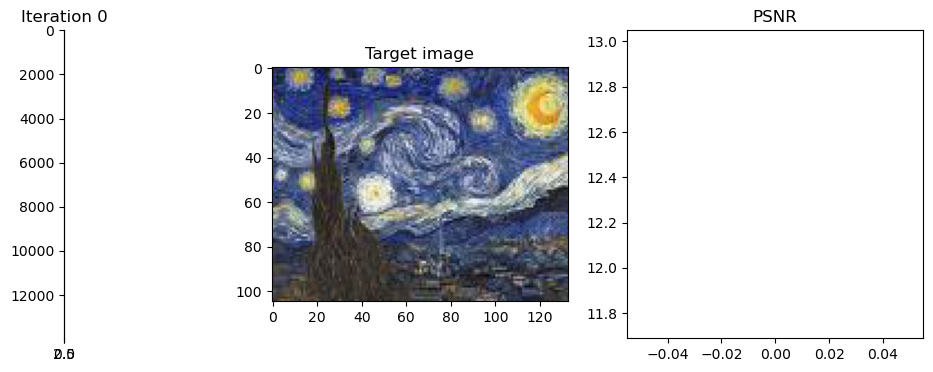

torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size(

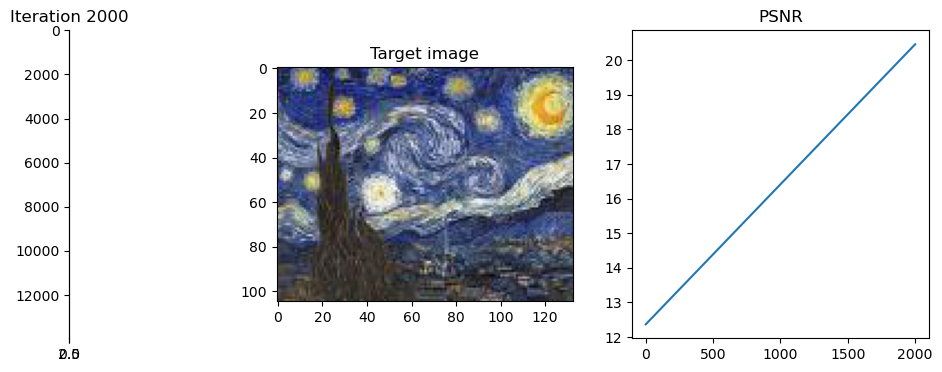

torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size(

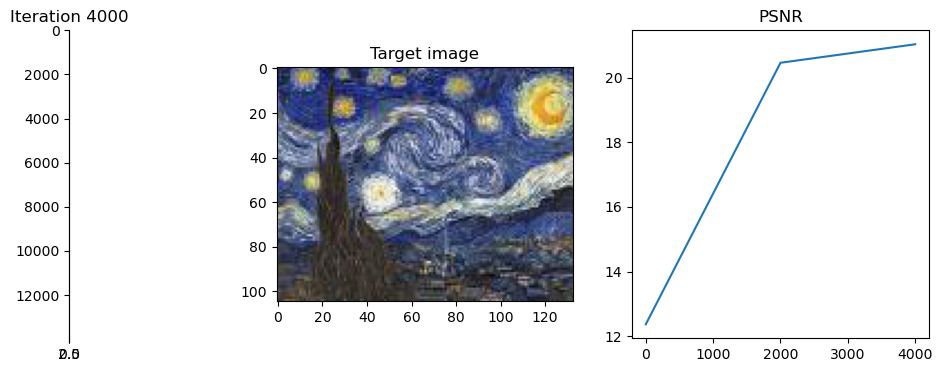

torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size(

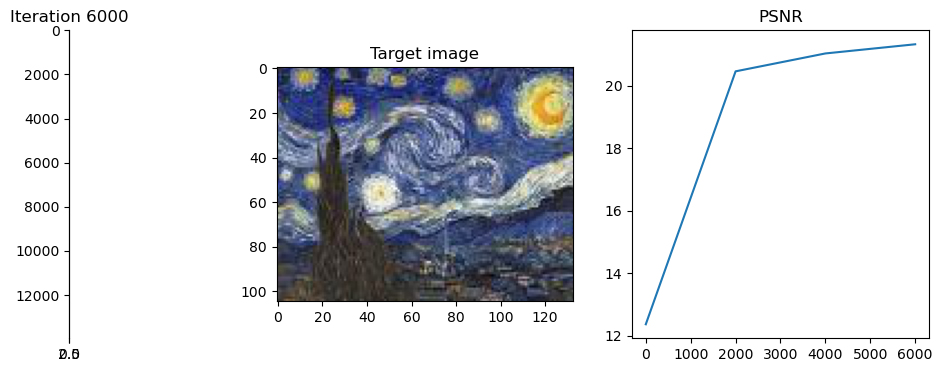

torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size(

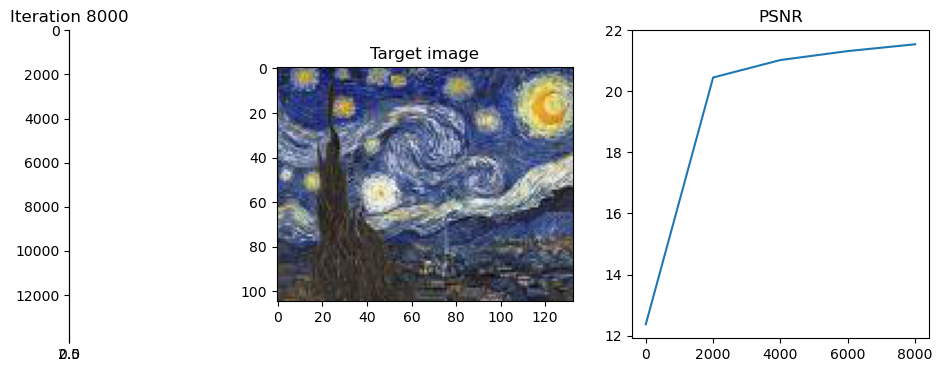

torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size([13965, 3])
torch.Size(

In [21]:
_ = train_2d_model(test_img=painting, num_frequencies=2, device=device)

### Part 2: Fitting a 3D Image

In [ ]:
import os
import gdown
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# url = "https://drive.google.com/file/d/13eBK_LWxs4SkruFKH7glKK9jwQU1BkXK/view?usp=sharing"
# gdown.download(url=url, output='lego_data.npz', quiet=False, fuzzy=True)

Here, we load the data that is comprised by the images, the R and T matrices of each camera position with respect to the world coordinates and the intrinsics parameters K of the camera.

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)
print(poses.shape)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

print(data)

2.1 Complete the following function that calculates the rays that pass through all the pixels of an HxW image

In [ ]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):
    """
    Compute the origin and direction of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height: the height of an image.
    width: the width of an image.
    intrinsics: camera intrinsics matrix of shape (3, 3).
    w_R_c: Rotation matrix of shape (3,3) from camera to world coordinates.
    w_T_c: Translation vector of shape (3,1) that transforms from camera to world coordinates.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape (height, width, 3) denoting the centers of
      each ray. Note that desipte that all ray share the same origin, here we ask you to return
      the ray origin for each ray as (height, width, 3).
    ray_directions (torch.Tensor): A tensor of shape (height, width, 3) denoting the
      direction of each ray.
    """

    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder

    #############################  TODO 2.1 BEGIN  ##########################
    y, x = torch.meshgrid(
        torch.arange(height, device=device), torch.arange(width, device=device)
    )
    pixel_coords = torch.stack(
        [x, y, torch.ones_like(x)], dim=-1
    ).float()  # Shape：[height, width, 3]

    # Transform the directions to world coordinates using the intrinsics and the rotation matrix
    camera_coords = torch.matmul(
        torch.linalg.inv(intrinsics).unsqueeze(0).unsqueeze(0),
        pixel_coords.unsqueeze(-1),
    )
    camera_coords = camera_coords.squeeze(-1)  # Shape：[height, width, 3]
    ray_directions = torch.matmul(
        w_R_c.unsqueeze(0).unsqueeze(0), camera_coords.unsqueeze(-1)
    )
    ray_directions = ray_directions.squeeze(-1)  # Shape：[height, width, 3]
    ray_directions = torch.nn.functional.normalize(ray_directions, dim=-1)  # Normalize the directions

    # The ray origins in world coordinates are the same and given by the translation vector
    ray_origins[:] = w_T_c

    #############################  TODO 2.1 END  ############################
    return ray_origins, ray_directions

Complete the next function to visualize how is the dataset created. You will be able to see from which point of view each image has been captured for the 3D object. What we want to achieve here, is to being able to interpolate between these given views and synthesize new realistic views of the 3D object.

In [ ]:
def plot_all_poses(poses):
    #############################  TODO 2.1 BEGIN  ############################
    origins = []  # To store all origins
    directions = []  # To store all directions

    for pose in poses:
        # Extract the translation part as the origin
        origin = pose[:3, 3]
        origins.append(origin)

        # Assume intrinsic matrix and image center coordinates (u0, v0)
        focal_length = 1  # Assume a focal length of 1, adjust as necessary
        u0, v0 = 0, 0  # Assume image center coordinates are (0, 0), adjust as necessary
        direction = np.linalg.inv(pose[:3, :3]) @ np.array([u0, v0, focal_length])
        direction = direction / np.linalg.norm(
            direction
        )  # Normalize the direction vector
        directions.append(direction)

    origins = np.stack(origins)
    directions = np.stack(directions)

    #############################  TODO 2.1 END  ############################

    ax = plt.figure(figsize=(12, 8)).add_subplot(projection="3d")
    _ = ax.quiver(
        origins[..., 0].flatten(),
        origins[..., 1].flatten(),
        origins[..., 2].flatten(),
        directions[..., 0].flatten(),
        directions[..., 1].flatten(),
        directions[..., 2].flatten(),
        length=0.12,
        normalize=True,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("z")
    plt.show()


plot_all_poses(data["poses"])

2.2 Complete the following function to implement the sampling of points along a given ray.

In [ ]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):
    """
    Sample 3D points on the given rays. The near and far variables indicate the bounds of sampling range.

    Args:
    ray_origins: Origin of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    ray_directions: Direction of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    near: The 'near' extent of the bounding volume.
    far:  The 'far' extent of the bounding volume.
    samples: Number of samples to be drawn along each ray.

    Returns:
    ray_points: Query 3D points along each ray. Shape: (height, width, samples, 3).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).
    """

    #############################  TODO 2.2 BEGIN  ############################
    # Get the device and dtype from the input to create new tensors
    device = ray_origins.device
    dtype = ray_origins.dtype

    # Create evenly spaced depth samples within the range [near, far]
    depth_step = (far - near) / samples
    depth_points = torch.arange(near, far, depth_step, device=device, dtype=dtype)
    depth_points = depth_points.unsqueeze(0).unsqueeze(0)
    depth_points = depth_points.expand(ray_origins.shape[0], ray_origins.shape[1], -1)

    # Compute the sampled points along the direction of the rays
    ray_points = ray_origins.unsqueeze(2) + ray_directions.unsqueeze(
        2
    ) * depth_points.unsqueeze(-1)

    #############################  TODO 2.2 END  ############################
    return ray_points, depth_points

2.3 Define the network architecture of NeRF along with a function that divided data into chunks to avoid memory leaks during training.

In [ ]:
class nerf_model(nn.Module):

    """
    Define a NeRF model comprising eight fully connected layers and following the
    architecture described in the NeRF paper.
    """

    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

        #############################  TODO 2.3 BEGIN  ############################
        # for autograder compliance, please follow the given naming for your layers
        self.L_pos = num_x_frequencies
        self.L_dir = num_d_frequencies

        # Calculate the lengths of encoded position and direction vectors
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        # Define MLP layers
        self.layers = nn.ModuleDict(
            {
                "layer_1": nn.Linear(pos_enc_feats, filter_size),
                "layer_2": nn.Linear(filter_size, filter_size),
                "layer_3": nn.Linear(filter_size, filter_size),
                "layer_4": nn.Linear(filter_size, filter_size),
                "layer_5": nn.Linear(filter_size, filter_size),
                "layer_6": nn.Linear(filter_size + pos_enc_feats, filter_size),
                "layer_7": nn.Linear(filter_size, filter_size),
                "layer_8": nn.Linear(filter_size, filter_size),
                "sigma_layer": nn.Linear(filter_size, 1),
                "feature_vector": nn.Linear(filter_size, filter_size),
                "pre_final_layer": nn.Linear(
                    dir_enc_feats + filter_size, filter_size // 2
                ),
                "final_layer": nn.Linear(filter_size // 2, 3),
            }
        )

    def forward(self, x, d):
        # Forward pass through early layers
        h = F.relu(self.layers["layer_1"](x))
        h = F.relu(self.layers["layer_2"](h))
        h = F.relu(self.layers["layer_3"](h))
        h = F.relu(self.layers["layer_4"](h))

        # Skip connection after the fifth layer
        skip = torch.cat([x, F.relu(self.layers["layer_5"](h))], dim=-1)

        # Remaining layers
        h = F.relu(self.layers["layer_6"](skip))
        h = F.relu(self.layers["layer_7"](h))
        h = self.layers["layer_8"](h)  # No activation

        # Predict volume density sigma
        sigma = F.relu(self.layers["sigma_layer"](h))

        # Additional layers for color prediction
        feature_vector = F.relu(self.layers["feature_vector"](h))

        # Concatenate feature vector with direction encoding
        h = torch.cat([d, feature_vector], dim=-1)
        h = F.relu(self.layers["pre_final_layer"](h))
        rgb = torch.sigmoid(self.layers["final_layer"](h))

        #############################  TODO 2.3 END  ############################
        return rgb, sigma

In [ ]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):
    def get_chunks(inputs, chunksize=2**15):
        """
        This fuction gets an array/list as input and returns a list of chunks of the initial array/list
        """
        return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

    """
    This function returns chunks of the ray points and directions to avoid memory errors with the
    neural network. It also applies positional encoding to the input points and directions before
    dividing them into chunks, as well as normalizing and populating the directions.
    """
    #############################  TODO 2.3 BEGIN  ############################
    # Normalize ray directions and repeat for each point along the ray
    norm_ray_directions = F.normalize(ray_directions, dim=-1)
    norm_ray_directions = norm_ray_directions.unsqueeze(2).expand_as(ray_points)

    # Apply positional encoding to ray points and directions
    encoded_ray_points = positional_encoding(ray_points, num_x_frequencies)
    encoded_ray_directions = positional_encoding(norm_ray_directions, num_d_frequencies)

    # Flatten the vectors
    flat_ray_points = encoded_ray_points.reshape(-1, encoded_ray_points.shape[-1])
    flat_ray_directions = encoded_ray_directions.reshape(
        -1, encoded_ray_directions.shape[-1]
    )

    # Divide into chunks
    ray_points_batches = get_chunks(flat_ray_points)
    ray_directions_batches = get_chunks(flat_ray_directions)

    #############################  TODO 2.3 END  ############################

    return ray_points_batches, ray_directions_batches

2.4 Compute the compositing weights of samples on camera ray and then complete the volumetric rendering procedure to reconstruct a whole RGB image from the sampled points and the outputs of the neural network.

In [ ]:
def volumetric_rendering(rgb, s, depth_points):
    """
    Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    rgb: RGB color at each query location (X, Y, Z). Shape: (height, width, samples, 3).
    sigma: Volume density at each query location (X, Y, Z). Shape: (height, width, samples).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).

    Returns:
    rec_image: The reconstructed image after applying the volumetric rendering to every pixel.
    Shape: (height, width, 3)
    """

    #############################  TODO 2.4 BEGIN  ############################
    # Calculate the deltas (distance between adjacent sampled depth values)
    deltas = depth_points[..., 1:] - depth_points[..., :-1]
    # Append a very large value to the last delta to ensure that it does not affect the result
    deltas = torch.cat(
        [
            deltas,
            torch.tensor([1e10], device=deltas.device).expand(deltas[..., :1].shape),
        ],
        -1,
    )

    # Ensure sigma is passed through a ReLU to avoid negative densities
    sigma = F.relu(s)
    # Calculate the negative exponent for transmittance
    alpha = 1.0 - torch.exp(-sigma * deltas)
    # Calculate the transmittance T_i for each sample point
    T = torch.cumprod(
        torch.cat([torch.ones_like(sigma[..., :1]), 1.0 - alpha + 1e-10], -1), -1
    )[..., :-1]

    # Calculate the weighted colors
    weights = alpha * T
    rec_image = torch.sum(weights.unsqueeze(-1) * rgb, -2)

    #############################  TODO 2.4 END  ############################

    return rec_image

To test and visualize your implementation, independently of the previous and next steps of the
NeRF pipeline, you can load the sanity_volumentric.pt file, run your implementation of the volumetric function and expect to see the figure provided in the handout.


In [ ]:
# url = "https://drive.google.com/file/d/1ag6MqSh3h4KY10Mcx5fKxt9roGNLLILK/view?usp=sharing"
# gdown.download(url=url, output='sanity_volumentric.pt', quiet=False, fuzzy=True)
rbd = torch.load('sanity_volumentric.pt')

In [ ]:
r = rbd['rgb']
s = rbd['sigma']
depth_points = rbd['depth_points']
rec_image = volumetric_rendering(r, s, depth_points)

plt.figure(figsize=(10, 5))
plt.imshow(rec_image.detach().cpu().numpy())
plt.title(f'Volumentric rendering of a sphere with $\\sigma={0.2}$, on blue background')
plt.show()

2.5 Combine everything together. Given the pose position of a camera, compute the camera rays and sample the 3D points along these rays. Divide those points into batches and feed them to the neural network. Concatenate them and use them for the volumetric rendering to reconstructed the final image.

In [ ]:
def one_forward_pass(
    height,
    width,
    intrinsics,
    pose,
    near,
    far,
    samples,
    model,
    num_x_frequencies,
    num_d_frequencies,
):
    #############################  TODO 2.5 BEGIN  ############################
    # Step 1: Compute all the rays from the image
    ray_origins, ray_directions = get_rays(
        height, width, intrinsics, pose[:3, :3], pose[:3, 3]
    )

    # Step 2: Sample points from the rays
    ray_points, depth_points = stratified_sampling(
        ray_origins, ray_directions, near, far, samples
    )

    # Step 3: Divide data into batches to avoid memory errors
    ray_points_batches, ray_directions_batches = get_batches(
        ray_points, ray_directions, num_x_frequencies, num_d_frequencies
    )

    all_rgb = []
    all_sigma = []
    for points_batch, dirs_batch in zip(ray_points_batches, ray_directions_batches):
        rgb, sigma = model(points_batch, dirs_batch)
        all_rgb.append(rgb)
        all_sigma.append(sigma.view(-1, samples))  # Reshape sigma within each batch

    # Concatenate along the first dimension and then reshape to match the grid
    rgb = torch.cat(all_rgb, dim=0).view(height, width, samples, -1)
    sigma = torch.cat(all_sigma, dim=0).view(height, width, samples)

    # Step 5: Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(rgb, sigma, depth_points)
    #############################  TODO 2.5 END  ############################

    return rec_image

If you manage to pass the autograder for all the previous functions, then it is time to train a NeRF! We provide the hyperparameters for you, we initialize the NeRF model and its weights, and we define a couple lists that will be needed to store results.

In [ ]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [ ]:
for i in range(iterations + 1):
    #############################  TODO 2.6 BEGIN  ############################

    # choose randomly a picture for the forward pass
    image_num = images.size(0)
    random_number = np.random.randint(0, image_num)
    target_image = images[random_number]
    pose = poses[random_number]

    # Move the data to the appropriate device
    target_image = target_image.to(device)
    pose = pose.to(device)

    # Run one iteration of NeRF and get the rendered RGB image.
    rec_image = one_forward_pass(
        height,
        width,
        intrinsics,
        pose,
        near,
        far,
        samples,
        model,
        num_x_frequencies,
        num_d_frequencies,
    )

    # Compute mean-squared error between the predicted and target images. Backprop!
    # Compute the loss (MSE)
    loss = F.mse_loss(rec_image, target_image)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate PSNR
    psnr = -10 * torch.log10(loss)
    #############################  TODO 2.6 END  ############################

    # Display images/plots/stats
    if i % display == 0:
        with torch.no_grad():
            #############################  TODO 2.6 BEGIN  ############################
            # Render the held-out view
            random_number = np.random.randint(0, image_num)
            test_image = images[random_number]
            test_pose = poses[random_number]
            test_rec_image = one_forward_pass(
                height,
                width,
                intrinsics,
                test_pose,
                near,
                far,
                samples,
                model,
                num_x_frequencies,
                num_d_frequencies,
            )

        # calculate the loss and the psnr between the original test image and the reconstructed one.
        test_loss = F.mse_loss(test_rec_image, test_image)
        psnr = -10 * torch.log10(test_loss)

        #############################  TODO 2.6 END  ############################

        print(
            "Iteration %d " % i,
            "Loss: %.4f " % loss.item(),
            "PSNR: %.2f " % psnr.item(),
            "Time: %.2f secs per iter, " % ((time.time() - t) / display),
            "%.2f mins in total" % ((time.time() - t0) / 60),
        )

        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

plt.imsave("test_lego.png", test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(), "model_nerf.pt")
print("Done!")